In [ ]:
# This performs a CWT of each beat. As this is going to be a CWT of more widths, there needs to be extra padding
# on the sides of each CWT that is then cut off to get rid of boundary effects from the CWT

In [1]:
from scipy import signal
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pywt
import PIL
from PIL import Image
from skimage.transform import resize
import math
from pywt._doc_utils import boundary_mode_subplot


In [2]:
##### This is the function that performs the CWT of the beat 

def CWT(beat ,widths=np.arange(1,128)):
    # This performs a CWT of every channel of the segment, then adds and axis and stacks them
    # First find the number of channels in the segment
    num_leads = beat.shape[-1] 
    pad = 350
    # Before performing the CWT, the sides of the array need to be padded:
    padded_1 = np.pad(beat[:,0],(pad,pad),'edge')
    padded_2 = np.pad(beat[:,1],(pad,pad),'edge')
    beat = np.stack((padded_1,padded_2),axis=-1)
    
    # Now loop over every channel and perform the CWT:
    for i in range(num_leads):
        if i == 0:
            cwtmatr, freqs = pywt.cwt(beat[:,i], widths, 'cmor1.5-1')
            cwtha = abs(cwtmatr)
            
            # Need to cut off the ends of the CWT that were added to counter the edge effects
            cwtha = cwtha[:,pad:-pad]
            # Need to resize it to the correct shape
            resized1 = resize(cwtha, (128,128))
            
            # Normalise all the values 
            mean = np.mean(resized1)
            resized1 -= mean
            std = np.std(resized1)
            resized1 /= std
            
            resized1 = np.array(resized1, dtype=np.float32)
            sample = resized1[:,:,np.newaxis]
        else:
            cwtmatr, freqs = pywt.cwt(beat[:,i], widths, 'cmor1.5-1')
            cwtha = abs(cwtmatr)
            cwtha = cwtha[:,pad:-pad]
            resized1 = resize(cwtha, (128,128))
            
            # Normalise all the values 
            mean = np.mean(resized1)
            resized1 -= mean
            std = np.std(resized1)
            resized1 /= std

            resized1 = np.array(resized1, dtype=np.float32)
            resized1 = resized1[:,:,np.newaxis]
            sample = np.concatenate((sample,resized1),axis=-1)
        
    return sample

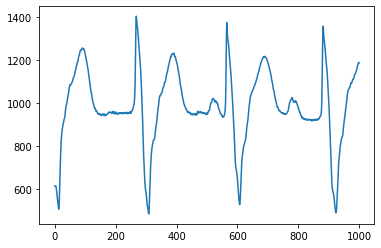

In [34]:
with open('7_array.pkl', 'rb') as f:
        ar = pickle.load(f)
plt.plot(ar[:1000,0])

In [3]:
with open('0_segments.pkl', 'rb') as f:
        data = pickle.load(f)


Text(0.5, 1.0, 'ECG of a Normal Beat')

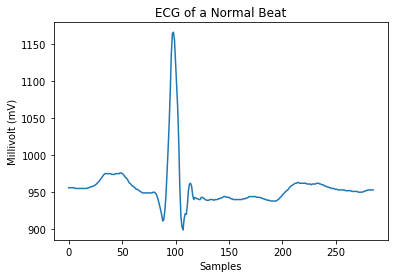

In [4]:
plt.plot(data[2][:,0])
plt.xlabel('Samples')
plt.ylabel('Millivolt (mV)')
plt.xlabel('Samples')
plt.title('ECG of a Normal Beat')
#plt.savefig('ECG of normal beat',dpi=200)

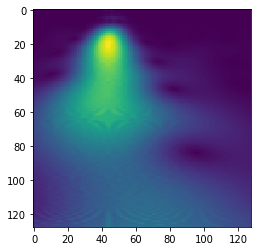

In [8]:
CWTed = CWT(data[2])
plt.imshow(CWTed[:,:,0])
#plt.colorbar()
#plt.title('CWT of a Normal Beat')
#plt.savefig('Test Aug',dpi=200)
with open('Test Aug.pkl','wb') as f:
    pickle.dump(CWTed,f)

In [20]:
np.save('test',CWTed ,allow_pickle = True)

In [29]:
# loop to find how many samples there will be 
num_samps = 0
for i in range(48):
    with open('Segmented Data/Segments/{}_segments.pkl'.format(i), 'rb') as f:
        segments = pickle.load(f)
        
    length = len(segments)
    num_samps += length
print(num_samps)
print('Size of all the data = ', num_samps * 129 , 'kb')

109261
Size of all the data =  14094669 kb


In [4]:
# This is a loop to perform a CWT of every sample
num_samps_total = 0
sample_labels = []
patient_samples = []
for i in range(48):
    print(i)
    
    with open('Segmented Data/Segments/{}_segments.pkl'.format(i), 'rb') as f:
        segments = pickle.load(f)
    with open('Segmented Data/Segment Labels/{}_Labels.pkl'.format(i), 'rb') as f:
        Labels = pickle.load(f)
    
    
    for j in range(len(segments)):
        # Append the sample label to sample_labels
        sample_labels.append(Labels[j])
        CWTed = CWT(segments[j])
        np.save('Segmented Data/Segments CWT/sample_{}'.format(num_samps_total),CWTed ,allow_pickle = True)
        num_samps_total += 1
        
    # Need to know which samples correspond to which patient for later on when we're combining the CNN
    # with the RNN     
    patient_samples.append(num_samps_total)
    # So I know where to start it again if it stops I will print this: 
    print('Number of samples for patient ',i,' is: ',num_samps_total)
with open('Segmented Data/sample_labels.pkl', 'wb') as f:
        pickle.dump(sample_labels, f)
        
with open('Segmented Data/patient_samples.pkl', 'wb') as f:
        pickle.dump(patient_samples, f)

0
Number of samples for patient  0  is:  2272
1
Number of samples for patient  1  is:  4140
2
Number of samples for patient  2  is:  6270
3
Number of samples for patient  3  is:  8353
4
Number of samples for patient  4  is:  9915
5
Number of samples for patient  5  is:  12516
6
Number of samples for patient  6  is:  14542
7
Number of samples for patient  7  is:  16678
8
Number of samples for patient  8  is:  18459
9
Number of samples for patient  9  is:  20990
10
Number of samples for patient  10  is:  23113
11
Number of samples for patient  11  is:  25651
12
Number of samples for patient  12  is:  27445
13
Number of samples for patient  13  is:  29324
14
Number of samples for patient  14  is:  31282
15
Number of samples for patient  15  is:  33693
16
Number of samples for patient  16  is:  35227
17
Number of samples for patient  17  is:  37514
18
Number of samples for patient  18  is:  39500
19
Number of samples for patient  19  is:  41362
20
Number of samples for patient  20  is:  43

In [1]:
# I need to load in the labels and convert the labels to numbers rather than strings
with open('Segmented Data/sample_labels.pkl', 'rb') as f:
        Labels = pickle.load(f)
        
#print(Labels)

# Need to turn the labels from strings to numbers that represent different types of beats
label_cat = [0 if b=='N'
            else 1 if b=='L'
            else 2 if b=='R'
            else 3 if b=='A'
            else 4 if b=='a'
            else 5 if b=='J'
            else 6 if b=='S'
            else 7 if b=='V'
            else 8 if b=='F'
            else 9 if b=='!'
            else 10 if b=='e'
            else 11 if b=='j'
            else 12 if b=='E'
            else 13 if b=='/'
            else 14 if b=='f'
            else 15 if b=='x'
            else 16 if b=='Q'
            else 17 for b in Labels]

with open('Segmented Data/sample_labels_cat.pkl', 'wb') as f:
        pickle.dump(label_cat, f)
        
print(label_cat[:10])

FileNotFoundError: [Errno 2] No such file or directory: 'Segmented Data/sample_labels.pkl'

In [22]:
# Now that the labels are numbers, I can use categorical encoding to make each label a vector of length
# 18 (18 types of labels) with a 1 in the label index.
import keras
from keras.utils.np_utils import to_categorical
one_hot_labels = to_categorical(label_cat)
with open('Segmented Data/sample_labels_cat.pkl', 'wb') as f:
        pickle.dump(label_cat, f)

Using TensorFlow backend.


In [23]:
one_hot_labels = to_categorical(label_cat)

In [30]:
print(len(one_hot_labels))
with open('Segmented Data/Sample_labels_OHE.pkl', 'wb') as f:
        pickle.dump(one_hot_labels, f)

109261


In [17]:
# I now need to make a list of all the sample ID's to be read in
sample_IDs = []
for i in range(len(Labels)):
    sample_IDs.append('Sample_{}'.format(i))
    
with open('Segmented Data/Sample_IDs.pkl', 'wb') as f:
        pickle.dump(Sample_IDs, f)